In [1]:
from nltk.corpus import stopwords
import string
import re
import findspark
findspark.init()
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql import SparkSession
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# removes stop words of a single Tweets (cleaned_str/row/document)
def remove_stops(data_str):
    # expects a string
    stops = set(stopwords.words("english"))
    list_pos = 0
    cleaned_str = ''
    text = data_str.split()
    for word in text:
        if word not in stops:
            # rebuild cleaned_str
            if list_pos == 0:
                cleaned_str = word
            else:
                cleaned_str = cleaned_str + ' ' + word
            list_pos += 1
    return cleaned_str

def check_blanks(data_str):
    is_blank = str(data_str.isspace())
    return is_blank

In [3]:
sc = pyspark.SparkContext()
sqlContext = SQLContext(sc)

In [4]:
remove_stops_udf = udf(remove_stops, StringType())
check_blanks_udf = udf(check_blanks, StringType())

In [5]:
hockey = sqlContext.read.csv('spelling_corrections_hash_mentions.csv', header=True)

In [6]:
hockey = hockey.filter("tweet_1 is not NULL")

In [7]:
hockey.show()

+---+----+--------------------+------------+
|_c0|hour|             tweet_1|        team|
+---+----+--------------------+------------+
|  0|  15|giveaway time ret...|     ['nyr']|
|  1|  15|canadiens gohabsg...|    ['habs']|
|  2|  15| lets do that hockey|    ['wild']|
|  3|  15|@dallasstars @ds_...|   ['stars']|
|  4|  15|@penguins happy b...|    ['pens']|
|  5|  15|a big weekend for...|    ['wild']|
|  6|  15|the learn to play...|    ['habs']|
|  7|  15|happy penguinawar...|    ['pens']|
|  8|  15|g47 201718 canuck...|  ['oilers']|
|  9|  15|its nyr game day ...|     ['nyr']|
| 10|  15|pretty much the o...|    ['caps']|
| 11|  15|stats with that g...| ['knights']|
| 12|  15|our wincats winfo...|['panthers']|
| 13|  15|welcome back canucks| ['canucks']|
| 14|  15|its nyr game day ...|     ['nyr']|
| 15|  15|limited lower lev...|   ['canes']|
| 16|  15|@penguins @attspo...|    ['pens']|
| 17|  15|blackhawks bobby ...|   ['hawks']|
| 18|  15|redwings hurrican...|   ['wings']|
| 19|  15|

In [8]:
hockey.dtypes

[('_c0', 'string'),
 ('hour', 'string'),
 ('tweet_1', 'string'),
 ('team', 'string')]

In [9]:
hockey.show()

+---+----+--------------------+------------+
|_c0|hour|             tweet_1|        team|
+---+----+--------------------+------------+
|  0|  15|giveaway time ret...|     ['nyr']|
|  1|  15|canadiens gohabsg...|    ['habs']|
|  2|  15| lets do that hockey|    ['wild']|
|  3|  15|@dallasstars @ds_...|   ['stars']|
|  4|  15|@penguins happy b...|    ['pens']|
|  5|  15|a big weekend for...|    ['wild']|
|  6|  15|the learn to play...|    ['habs']|
|  7|  15|happy penguinawar...|    ['pens']|
|  8|  15|g47 201718 canuck...|  ['oilers']|
|  9|  15|its nyr game day ...|     ['nyr']|
| 10|  15|pretty much the o...|    ['caps']|
| 11|  15|stats with that g...| ['knights']|
| 12|  15|our wincats winfo...|['panthers']|
| 13|  15|welcome back canucks| ['canucks']|
| 14|  15|its nyr game day ...|     ['nyr']|
| 15|  15|limited lower lev...|   ['canes']|
| 16|  15|@penguins @attspo...|    ['pens']|
| 17|  15|blackhawks bobby ...|   ['hawks']|
| 18|  15|redwings hurrican...|   ['wings']|
| 19|  15|

In [11]:
hockey = hockey.withColumn("stop_text", remove_stops_udf(hockey["tweet_1"]))

In [12]:
hockey.show()

+---+----+--------------------+------------+--------------------+
|_c0|hour|             tweet_1|        team|           stop_text|
+---+----+--------------------+------------+--------------------+
|  0|  15|giveaway time ret...|     ['nyr']|giveaway time ret...|
|  1|  15|canadiens gohabsg...|    ['habs']|canadiens gohabsg...|
|  2|  15| lets do that hockey|    ['wild']|         lets hockey|
|  3|  15|@dallasstars @ds_...|   ['stars']|@dallasstars @ds_...|
|  4|  15|@penguins happy b...|    ['pens']|@penguins happy b...|
|  5|  15|a big weekend for...|    ['wild']|big weekend minne...|
|  6|  15|the learn to play...|    ['habs']|learn play progra...|
|  7|  15|happy penguinawar...|    ['pens']|happy penguinawar...|
|  8|  15|g47 201718 canuck...|  ['oilers']|g47 201718 canuck...|
|  9|  15|its nyr game day ...|     ['nyr']|nyr game day aval...|
| 10|  15|pretty much the o...|    ['caps']|pretty much thing...|
| 11|  15|stats with that g...| ['knights']|stats goal wild b...|
| 12|  15|

In [13]:
hockey = hockey.withColumn("is_blank", check_blanks_udf(hockey["stop_text"]))
hockey.show()

+---+----+--------------------+------------+--------------------+--------+
|_c0|hour|             tweet_1|        team|           stop_text|is_blank|
+---+----+--------------------+------------+--------------------+--------+
|  0|  15|giveaway time ret...|     ['nyr']|giveaway time ret...|   False|
|  1|  15|canadiens gohabsg...|    ['habs']|canadiens gohabsg...|   False|
|  2|  15| lets do that hockey|    ['wild']|         lets hockey|   False|
|  3|  15|@dallasstars @ds_...|   ['stars']|@dallasstars @ds_...|   False|
|  4|  15|@penguins happy b...|    ['pens']|@penguins happy b...|   False|
|  5|  15|a big weekend for...|    ['wild']|big weekend minne...|   False|
|  6|  15|the learn to play...|    ['habs']|learn play progra...|   False|
|  7|  15|happy penguinawar...|    ['pens']|happy penguinawar...|   False|
|  8|  15|g47 201718 canuck...|  ['oilers']|g47 201718 canuck...|   False|
|  9|  15|its nyr game day ...|     ['nyr']|nyr game day aval...|   False|
| 10|  15|pretty much the

In [14]:
hockey = hockey.filter(hockey["is_blank"] == "False")

In [15]:
drop_list = ['tweet_1', 'created_at', 'is_blank','_co']

hockey = hockey.select([column for column in hockey.columns if column not in drop_list])

In [20]:
myIndex = 14741
values = (hockey.rdd.zipWithIndex()
            .filter(lambda ((l, v), i): i == myIndex)
            .map(lambda ((l,v), i): (l, v))
            .collect())

print(values[0])

SyntaxError: invalid syntax (<ipython-input-20-baf0f9a7345d>, line 3)

In [16]:
hockey_df = hockey.toPandas()

In [17]:
hockey_df.iloc[14741]

_c0                14741
hour                  20
team         ['jackets']
stop_text               
Name: 14741, dtype: object

In [17]:
hockey_df.head()

,_c0,hour,team,stop_text
0,0,15,['nyr'],giveaway time retweet follow enter buch scores...
1,1,15,['habs'],canadiens gohabsgo habs canadiens untouchable ...
2,2,15,['wild'],lets hockey
3,3,15,['stars'],@dallasstars @ds_foundation ed friggin belfour...
4,4,15,['pens'],@penguins happy birthday ryan grim reaper reaves


In [18]:
hockey_df = hockey_df.drop('_c0', 1)

In [19]:
hockey_df.head()

,hour,team,stop_text
0,15,['nyr'],giveaway time retweet follow enter buch scores...
1,15,['habs'],canadiens gohabsgo habs canadiens untouchable ...
2,15,['wild'],lets hockey
3,15,['stars'],@dallasstars @ds_foundation ed friggin belfour...
4,15,['pens'],@penguins happy birthday ryan grim reaper reaves


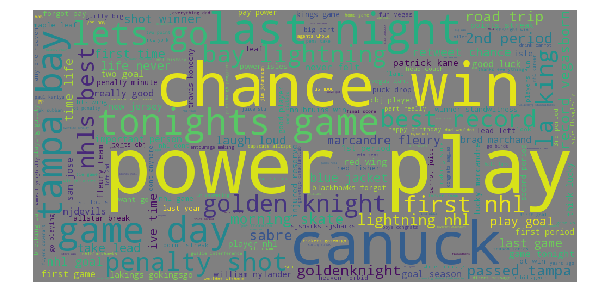

In [22]:
wordcloud = WordCloud(width = 1000, height = 500,background_color='grey').generate(' '.join(hockey_df['stop_text']))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [23]:
hockey_df.to_csv('no_stops.csv')